# Initialize the accelerator

In [1]:
from finn_examples import models
accel = models.cnv_w1a1_gtsrb()

In [2]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal), str(accel.idt)))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal), str(accel.odt)))

Expected input shape and datatype: (1, 32, 32, 3) UINT8
Expected output shape and datatype: (1, 44) INT16


# Load the GTSRB dataset

In [3]:
from os import path
import urllib
import numpy as np
dataset_local = "/tmp/traffic-signs-data.zip"
if not path.isfile(dataset_local):
    dataset_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip"
    urllib.request.urlretrieve(dataset_url, dataset_local)
    ! unzip {dataset_local} -d /tmp

dataset_dict = np.load("/tmp/test.p")
testx = dataset_dict["features"]
testy = dataset_dict["labels"]

In [4]:
gtsrb_classes = [
    '20 Km/h', 
    '30 Km/h', 
    '50 Km/h', 
    '60 Km/h', 
    '70 Km/h', 
    '80 Km/h', 
    'End 80 Km/h', 
    '100 Km/h', 
    '120 Km/h', 
    'No overtaking', 
    'No overtaking for large trucks', 
    'Priority crossroad', 
    'Priority road', 
    'Give way', 
    'Stop', 
    'No vehicles', 
    'Prohibited for vehicles with a permitted gross weight over 3.5t including their trailers, and for tractors except passenger cars and buses', 
    'No entry for vehicular traffic', 
    'Danger Ahead', 
    'Bend to left', 
    'Bend to right', 
    'Double bend (first to left)', 
    'Uneven road', 
    'Road slippery when wet or dirty', 
    'Road narrows (right)', 
    'Road works', 
    'Traffic signals', 
    'Pedestrians in road ahead', 
    'Children crossing ahead', 
    'Bicycles prohibited', 
    'Risk of snow or ice', 
    'Wild animals', 
    'End of all speed and overtaking restrictions', 
    'Turn right ahead', 
    'Turn left ahead', 
    'Ahead only', 
    'Ahead or right only', 
    'Ahead or left only', 
    'Pass by on right', 
    'Pass by on left', 
    'Roundabout', 
    'End of no-overtaking zone', 
    'End of no-overtaking zone for vehicles with a permitted gross weight over 3.5t including their trailers, and for tractors except passenger cars and buses', 
    'Not a roadsign'
]

In [10]:
print("Dataset shape is " + str(testx.shape))

Dataset shape is (12630, 32, 32, 3)


# Classify a single image

In [5]:
test_single_x = testx[0]
test_single_y = testy[0]

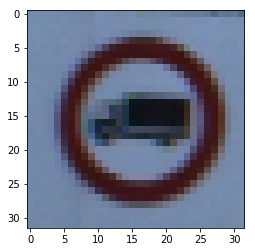

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.imshow(test_single_x)
plt.show()

In [7]:
print("Expected class is:\n%s" % (gtsrb_classes[test_single_y]))

Expected class is:
Prohibited for vehicles with a permitted gross weight over 3.5t including their trailers, and for tractors except passenger cars and buses


In [8]:
accel_y = accel.execute(test_single_x.reshape(accel.ishape_normal))
print("Accelerator result is:\n%s" % (gtsrb_classes[np.argmax(accel_y)]))

Accelerator result is:
Prohibited for vehicles with a permitted gross weight over 3.5t including their trailers, and for tractors except passenger cars and buses


# Validate accuracy on GTSRB test set

In [20]:
batch_size = 421
total = testx.shape[0]
accel.batch_size = batch_size
n_batches = int(total / batch_size)

batch_imgs = testx.reshape(n_batches, batch_size, -1)
batch_labels = testy.reshape(n_batches, batch_size)
obuf_normal = np.empty_like(accel.obuf_packed_device)
print("Ready to run validation, test images tensor has shape %s" % str(batch_imgs.shape))
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed), str(accel.oshape_packed)) )

Ready to run validation, test images tensor has shape (30, 421, 3072)
Accelerator buffer shapes are (421, 1, 32, 32, 3, 1) for input, (421, 11, 8) for output


In [24]:
ok = 0
nok = 0
for i in range(n_batches):
    ibuf_normal = batch_imgs[i].reshape(accel.ibuf_packed_device.shape)
    exp = batch_labels[i]
    # to avoid the slower software implementation during data unpacking,
    # we make manual calls to buffer copies and execute_on_buffers
    # all this could have been replaced with accel.execute() otherwise
    accel.copy_input_data_to_device(ibuf_normal)
    accel.execute_on_buffers()
    obuf_normal = np.empty_like(accel.obuf_packed_device)
    accel.copy_output_data_from_device(obuf_normal)
    # this line provides fast unpacking using numpy primitives
    # instead of using FINN's unpack functions
    quick_out = obuf_normal.view(np.uint16).reshape(accel.batch_size, 44)
    obuf_argmax = np.argmax(quick_out, axis=-1)
    ok_batch = (obuf_argmax == exp).sum()
    nok_batch = (batch_size-ok_batch)
    ok += ok_batch
    nok += nok_batch
    
    print("batch %d / %d : total OK %d NOK %d" % (i+1, n_batches, ok, nok))

batch 0 / 30 : total OK 401 NOK 20
batch 1 / 30 : total OK 798 NOK 44
batch 2 / 30 : total OK 1203 NOK 60
batch 3 / 30 : total OK 1605 NOK 79
batch 4 / 30 : total OK 2003 NOK 102
batch 5 / 30 : total OK 2404 NOK 122
batch 6 / 30 : total OK 2806 NOK 141
batch 7 / 30 : total OK 3210 NOK 158
batch 8 / 30 : total OK 3609 NOK 180
batch 9 / 30 : total OK 4009 NOK 201
batch 10 / 30 : total OK 4404 NOK 227
batch 11 / 30 : total OK 4805 NOK 247
batch 12 / 30 : total OK 5205 NOK 268
batch 13 / 30 : total OK 5605 NOK 289
batch 14 / 30 : total OK 5996 NOK 319
batch 15 / 30 : total OK 6403 NOK 333
batch 16 / 30 : total OK 6796 NOK 361
batch 17 / 30 : total OK 7200 NOK 378
batch 18 / 30 : total OK 7596 NOK 403
batch 19 / 30 : total OK 7994 NOK 426
batch 20 / 30 : total OK 8397 NOK 444
batch 21 / 30 : total OK 8804 NOK 458
batch 22 / 30 : total OK 9213 NOK 470
batch 23 / 30 : total OK 9616 NOK 488
batch 24 / 30 : total OK 10010 NOK 515
batch 25 / 30 : total OK 10414 NOK 532
batch 26 / 30 : total OK 1

In [25]:
acc = 100.0 * ok / (total)
print("Final accuracy: {}%".format(acc))

Final accuracy: 95.17814726840855%


# Run built-in benchmarks

In [26]:
accel.batch_size = 100
accel.throughput_test()

{'DRAM_in_bandwidth[MB/s]': 8.867975173609915,
 'DRAM_out_bandwidth[MB/s]': 0.25403053882736737,
 'batch_size': 100,
 'copy_input_data_to_device[ms]': 2.284526824951172,
 'copy_output_data_from_device[ms]': 0.20766258239746094,
 'fclk[mhz]': 100.0,
 'fold_input[ms]': 0.14352798461914062,
 'pack_input[ms]': 0.10251998901367188,
 'runtime[ms]': 34.64150428771973,
 'throughput[images/s]': 2886.7106684928112,
 'unfold_output[ms]': 0.0762939453125,
 'unpack_output[ms]': 1504.5325756072998}